In [1]:
import torch.nn as nn
import torch.nn.functional as F
from fbm_dropout.fbm_dropout import DropoutFBM

class DenseNetFBM(nn.Module):

    def __init__(self, hidden_sizes, n_agents, max_epoch, grid_sizes, device=None, dtype=None):

        super().__init__()
        
        self.linear_1 = nn.Linear(28*28, hidden_sizes[0], device=device, dtype=dtype)
        self.linear_2 = nn.Linear(hidden_sizes[0], hidden_sizes[1], device=device, dtype=dtype)
        self.linear_3 = nn.Linear(hidden_sizes[1], 10, device=device, dtype=dtype)
        self.dropout_1 = DropoutFBM(0.8, n_agents[0], max_epoch, grid_sizes[0], show=True, device=device, dtype=dtype)
        self.dropout_2 = DropoutFBM(0.8, n_agents[1], max_epoch, grid_sizes[1], show=True, device=device, dtype=dtype)

    def forward(self, input, current_epoch):

        if self.training:
            output = F.relu(self.dropout_1(self.linear_1(input), current_epoch))
            output = F.relu(self.dropout_2(self.linear_2(output), current_epoch))
        else:
            output = F.relu(self.linear_1(input))
            output = F.relu(self.linear_2(output))
            
        output = self.linear_3(output)
        
        return output

In [2]:
from torchvision import datasets, transforms
import torch

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

trainset = datasets.MNIST('~/datasets', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/datasets', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
import torch.optim as optim

hidden_sizes = [256, 64]
max_epochs = 200
grid_sizes = [(16,16), (8,8)]
n_agents = [32, 8]
device='cuda'

'''
model = DenseNet(hidden_sizes, 0, device=device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_dropout = DenseNet(hidden_sizes, .2, device=device)
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=0.001)

'''
model_fbm_dropout = DenseNetFBM(hidden_sizes, n_agents, max_epochs, grid_sizes, device=device)
optimizer_fbm_dropout = optim.Adam(model_fbm_dropout.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

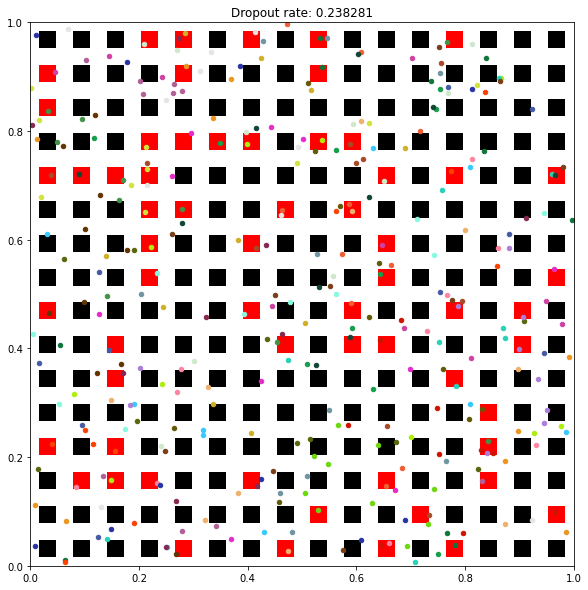

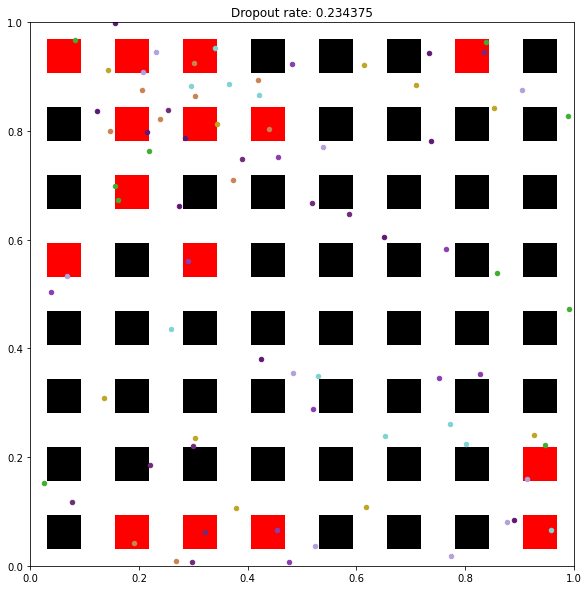

Epoch 0
FBM Dropout: Train Loss 0.38, Test Acc 0.93, Drop Rate 0.24 0.23


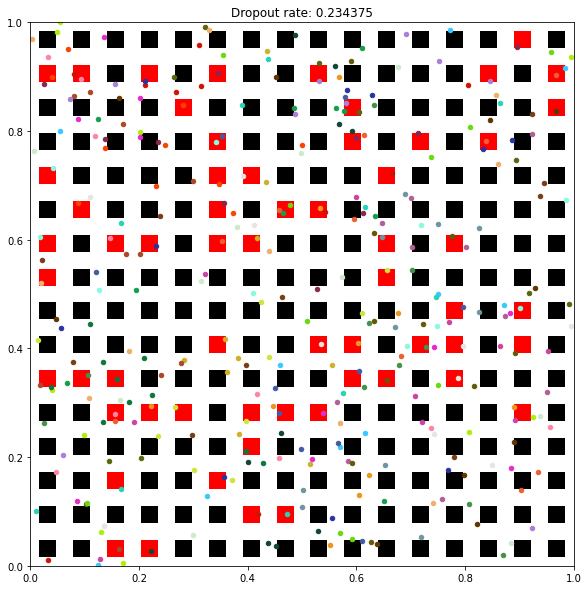

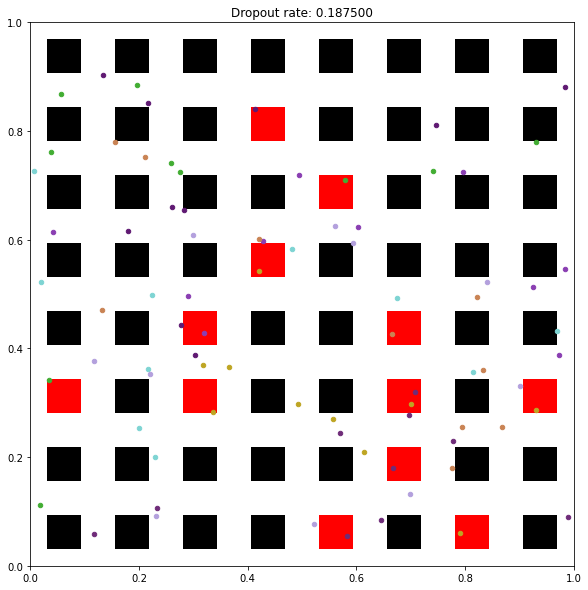

Epoch 1
FBM Dropout: Train Loss 0.19, Test Acc 0.93, Drop Rate 0.24 0.21
How many agents stayed on the same neuron?
0.66796875
0.609375


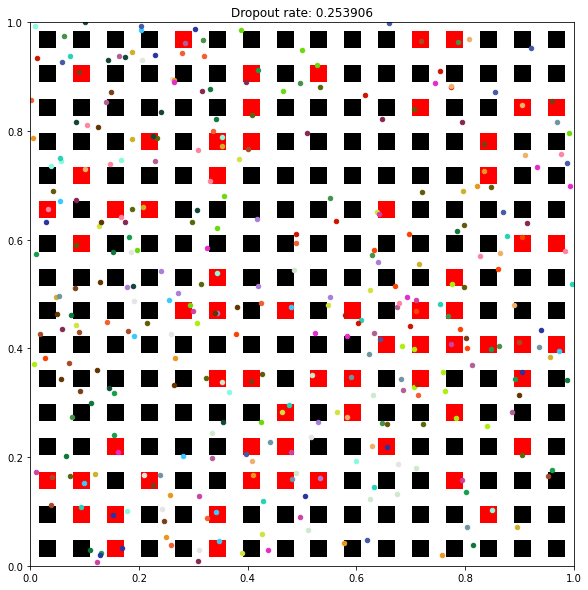

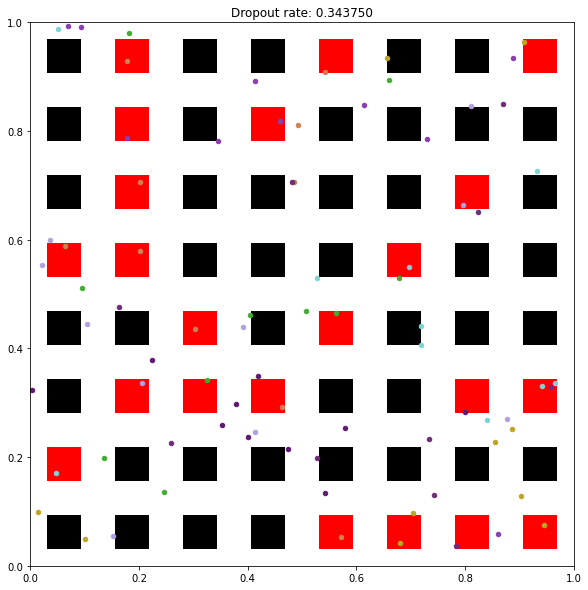

Epoch 2
FBM Dropout: Train Loss 0.15, Test Acc 0.94, Drop Rate 0.24 0.26
How many agents stayed on the same neuron?
0.62109375
0.65625


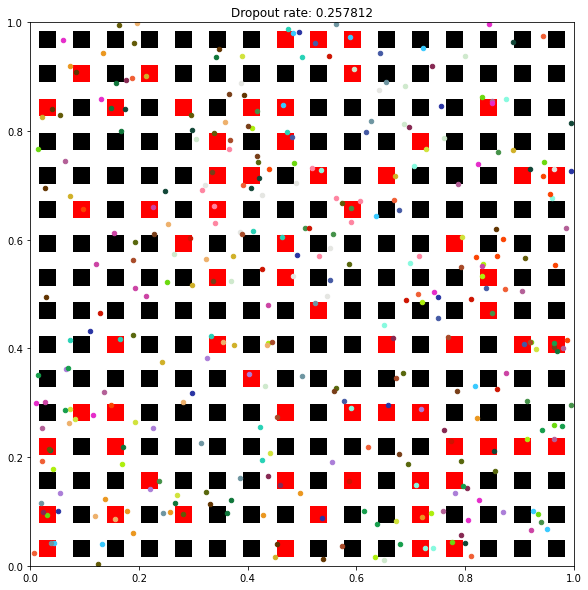

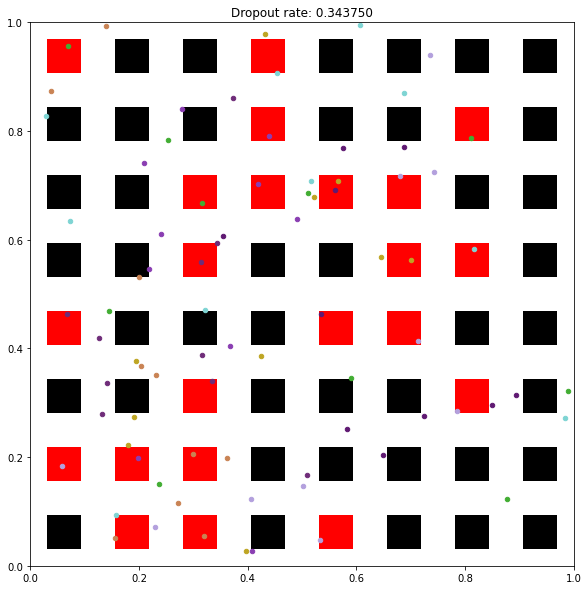

Epoch 3
FBM Dropout: Train Loss 0.13, Test Acc 0.90, Drop Rate 0.25 0.28
How many agents stayed on the same neuron?
0.63671875
0.53125


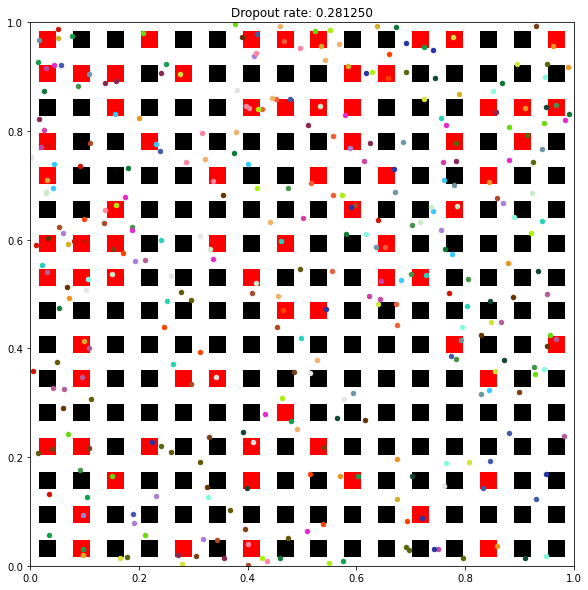

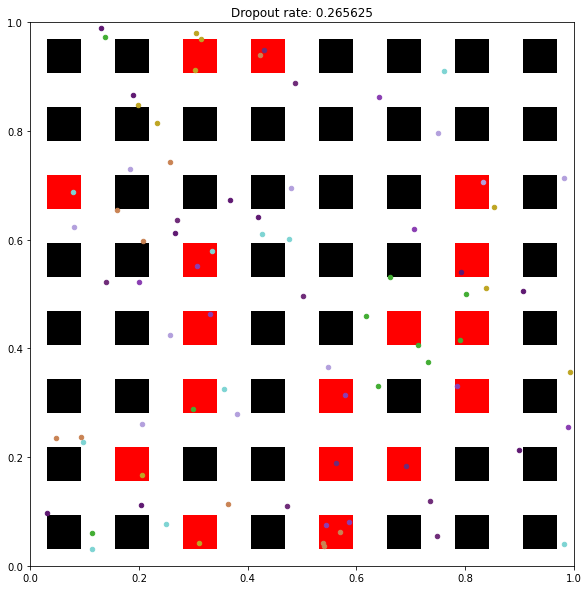

Epoch 4
FBM Dropout: Train Loss 0.12, Test Acc 0.95, Drop Rate 0.25 0.28
How many agents stayed on the same neuron?
0.6171875
0.671875


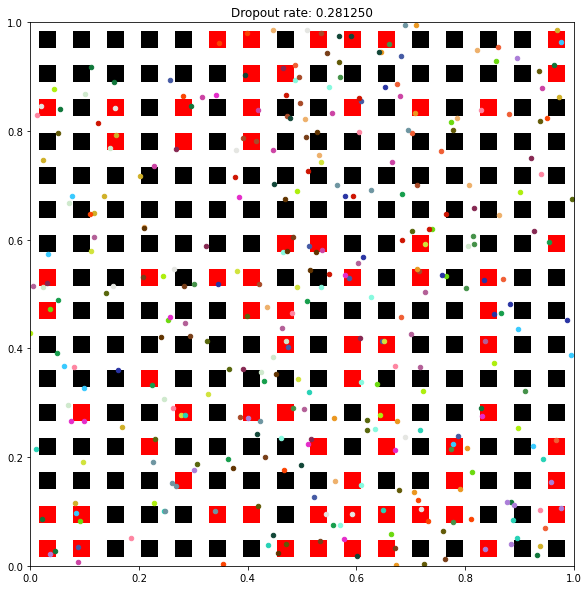

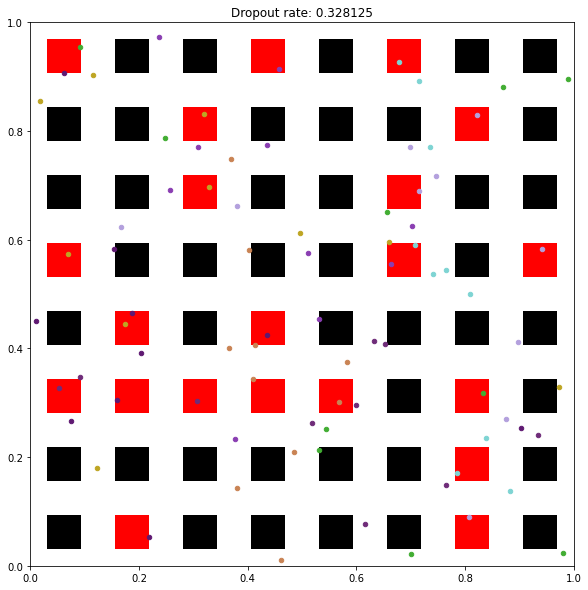

Epoch 5
FBM Dropout: Train Loss 0.11, Test Acc 0.96, Drop Rate 0.26 0.28
How many agents stayed on the same neuron?
0.59375
0.53125


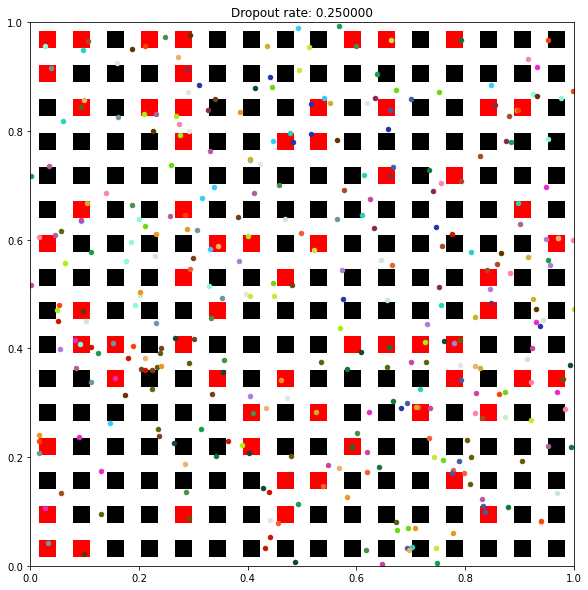

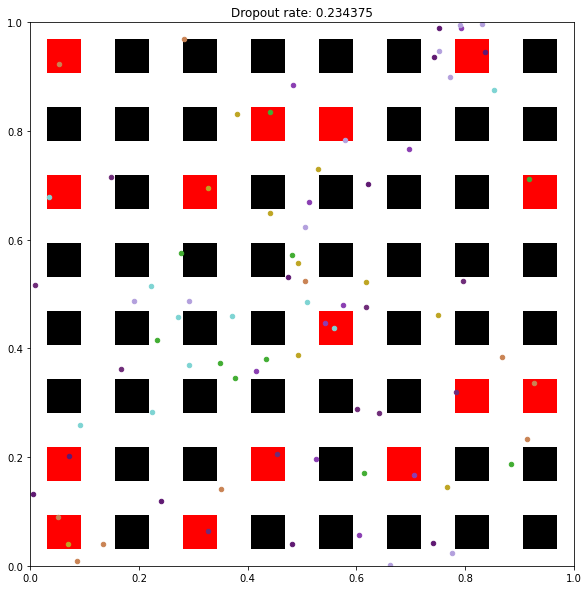

Epoch 6
FBM Dropout: Train Loss 0.10, Test Acc 0.95, Drop Rate 0.26 0.28
How many agents stayed on the same neuron?
0.6015625
0.53125


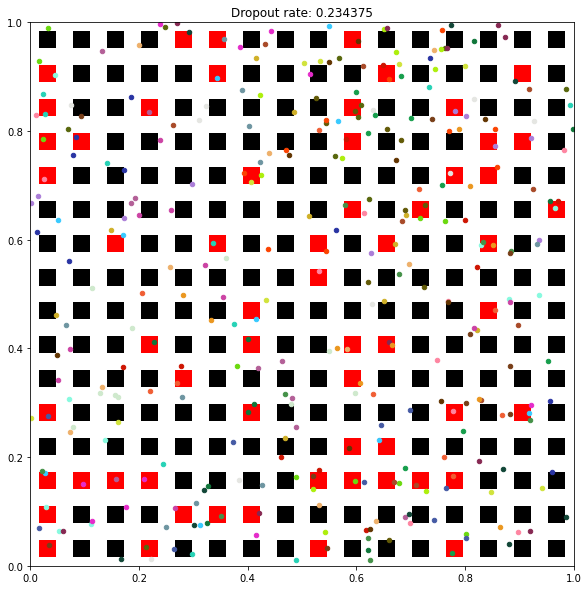

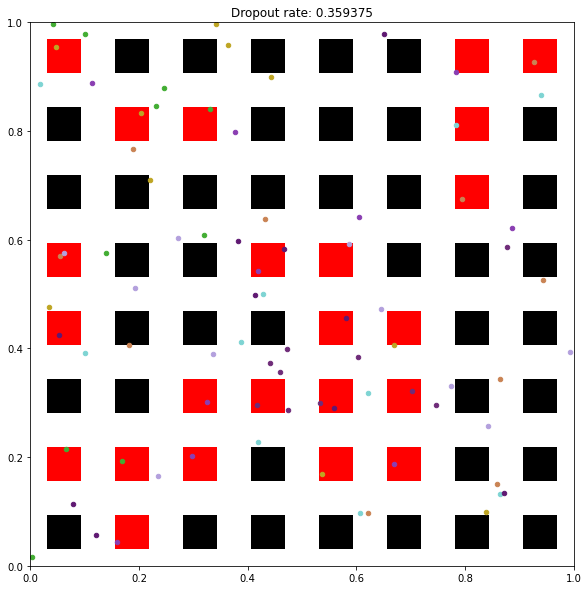

Epoch 7
FBM Dropout: Train Loss 0.10, Test Acc 0.96, Drop Rate 0.25 0.29
How many agents stayed on the same neuron?
0.6484375
0.5625


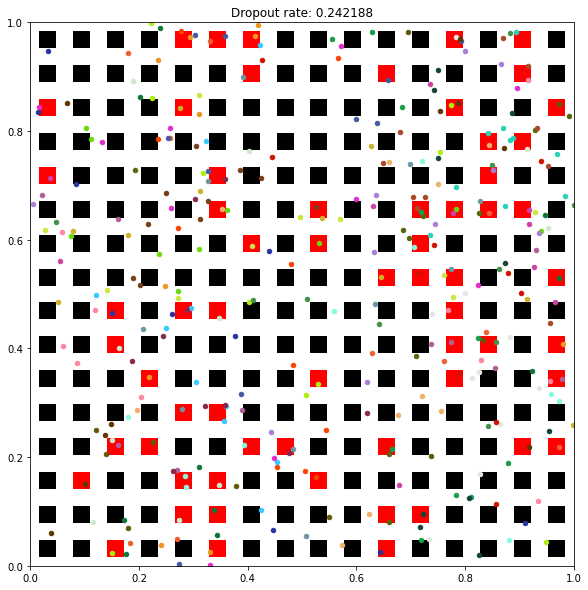

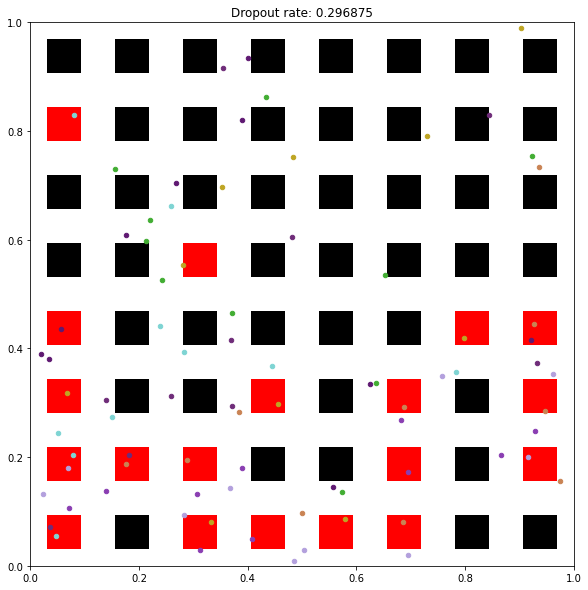

Epoch 8
FBM Dropout: Train Loss 0.09, Test Acc 0.97, Drop Rate 0.25 0.29
How many agents stayed on the same neuron?
0.65625
0.5625


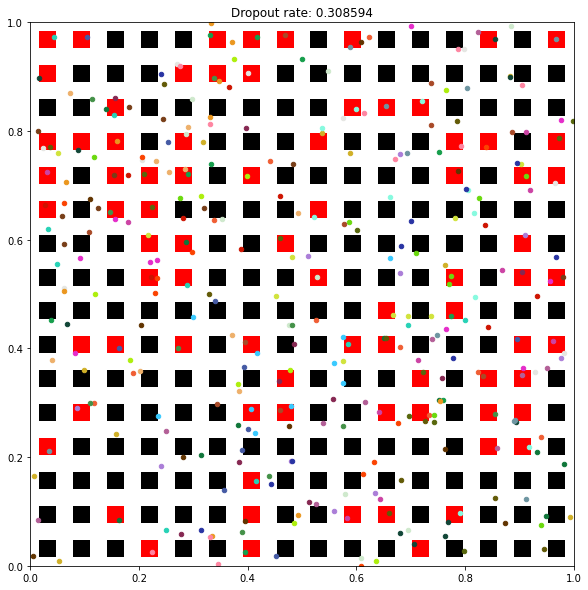

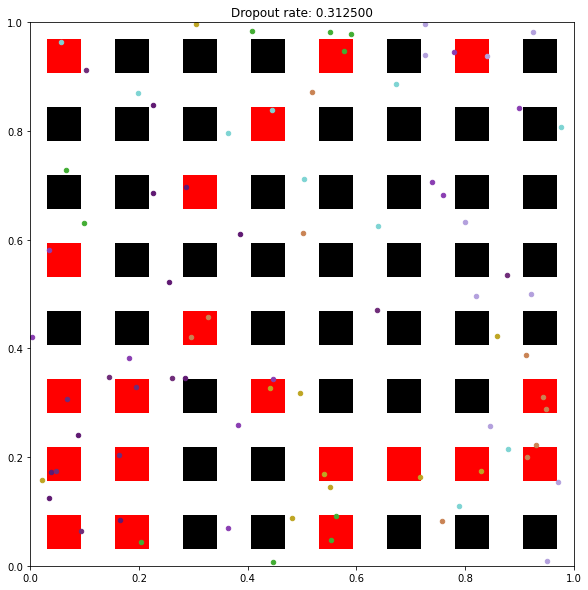

Epoch 9
FBM Dropout: Train Loss 0.09, Test Acc 0.97, Drop Rate 0.26 0.29
How many agents stayed on the same neuron?
0.55078125
0.671875


In [4]:
results = {}
results['train loss'] = {}
results['train loss']['fbm dropout'] = []
results['test acc'] = {}
results['test acc']['fbm dropout'] = []

prev_mask_1 = prev_mask_2 = None

for epoch in range(10):
    model_fbm_dropout.train()

    running_loss = {}
    running_loss['fbm dropout'] = 0.0
    for images, labels in train_loader:

        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)

        optimizer_fbm_dropout.zero_grad()
        output_fbm_dropout = model_fbm_dropout(images, epoch)
        loss_fbm_dropout = criterion(output_fbm_dropout, labels)
        loss_fbm_dropout.backward()
        optimizer_fbm_dropout.step()
        running_loss['fbm dropout'] += loss_fbm_dropout.item()

    results['train loss']['fbm dropout'].append(running_loss['fbm dropout'] / len(train_loader))

    model_fbm_dropout.eval()
    acc_fbm_dropout = 0.0
    for images, labels in test_loader:
        images = images.view(-1,784).to(device)
        labels = labels.to(device)

        output_fbm_dropout = model_fbm_dropout(images, epoch)
        _, pred_fbm_dropout = torch.max(output_fbm_dropout, axis=1)
        acc_fbm_dropout += torch.sum(pred_fbm_dropout==labels).item()

    results['test acc']['fbm dropout'].append(acc_fbm_dropout / len(testset))
    
    print('Epoch {}'.format(epoch))
    print('FBM Dropout: Train Loss {:.2f}, Test Acc {:.2f}, Drop Rate {:.2f} {:.2f}'.format(results['train loss']['fbm dropout'][-1], 
                                                                                     results['test acc']['fbm dropout'][-1], 
                                                                                     model_fbm_dropout.dropout_1.curr_dropout_rate, 
                                                                                     model_fbm_dropout.dropout_2.curr_dropout_rate))

    if epoch > 0:
        print("How many agents stayed on the same neuron?")
        print((torch.sum(prev_mask_1 == model_fbm_dropout.dropout_1.mask) / hidden_sizes[0]).item())
        print((torch.sum(prev_mask_2 == model_fbm_dropout.dropout_2.mask) / hidden_sizes[1]).item())
    prev_mask_1 = model_fbm_dropout.dropout_1.mask
    prev_mask_2 = model_fbm_dropout.dropout_2.mask